Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,314 (84.17 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 701ms/step - accuracy: 0.7844 - loss: 0.9171 - val_accuracy: 0.9710 - val_loss: 0.0864
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 708ms/step - accuracy: 0.9630 - loss: 0.0988 - val_accuracy: 0.9670 - val_loss: 0.0911
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 703ms/step - accuracy: 0.9722 - loss: 0.0806 - val_accuracy: 0.9750 - val_loss: 0.0770
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 826ms/step - accuracy: 0.9745 - loss: 0.0536 - val_accuracy: 0.9650 - val_loss: 0.0822
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 787ms/step - accuracy: 0.9799 - loss: 0.0520 - val_accuracy: 0.9660 - val_loss: 0.0959


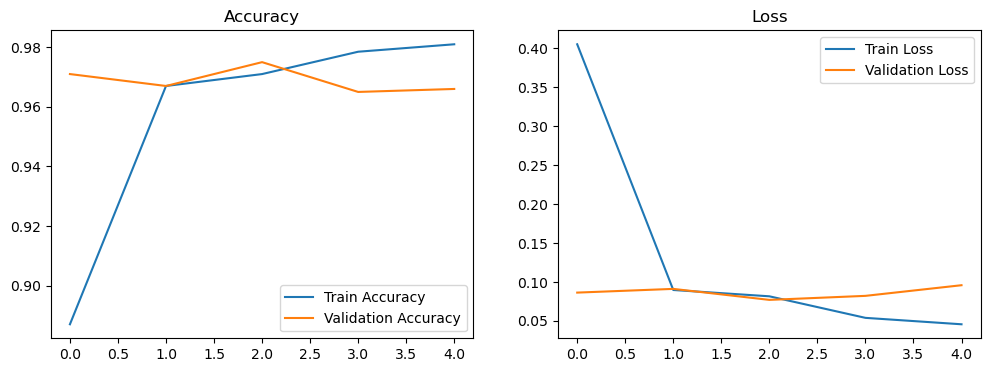

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step - accuracy: 0.9741 - loss: 0.0587
Validation accuracy: 0.9660, Loss: 0.0959


In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib
import zipfile
import urllib.request

# Enable mixed precision for speed on supported GPUs
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Download and extract Cats vs Dogs dataset
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = "cats_and_dogs_filtered.zip"
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

base_dir = pathlib.Path('cats_and_dogs_filtered')
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

# Parameters
IMG_HEIGHT, IMG_WIDTH = 160, 160
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001
NUM_CLASSES = 2

# Prepare datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocess inputs
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False,
                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(NUM_CLASSES, activation='softmax', dtype='float32')  # Output in float32
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

# Plot performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Evaluate model
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
